In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal

def radec_to_xyz(ra, dec):
    x = math.cos(np.deg2rad(dec)) * math.cos(np.deg2rad(ra))
    y = math.cos(np.deg2rad(dec)) * math.sin(np.deg2rad(ra))
    z = math.sin(np.deg2rad(dec))

    return np.array([x, y, z], dtype=np.float64)

#functions from sncosmo
def cmb_dz(ra, dec):
    """See http://arxiv.org/pdf/astro-ph/9609034
     CMBcoordsRA = 167.98750000 # J2000 Lineweaver
     CMBcoordsDEC = -7.22000000
    """

    # J2000 coords from NED
    CMB_DZ = 371000. / 299792458.
    CMB_RA = 168.01190437
    CMB_DEC = -6.98296811
    CMB_XYZ = radec_to_xyz(CMB_RA, CMB_DEC)

    coords_xyz = radec_to_xyz(ra, dec)
    
    dz = CMB_DZ * np.dot(CMB_XYZ, coords_xyz)

    return dz

def cmb_to_helio(z, ra, dec):
    """Convert from CMB-frame redshift to heliocentric redshift.
    
    Parameters
    ----------
    z : float
        CMB-frame redshift.
    ra, dec: float
        RA and Declination in degrees (J2000).
    """

    dz = -cmb_dz(ra, dec)
    one_plus_z_pec = math.sqrt((1. + dz) / (1. - dz))
    one_plus_z_helio = (1. + z) * one_plus_z_pec

    return one_plus_z_helio - 1.


In [2]:
def one_lenght_redshift(u):
    
    redshift_value = None
    
    #if there is kind in the list continue
    if "kind" in data[url]["redshift"][0]:

        #if its heliocentric pick then
        if data[url]["redshift"][0]["kind"] == "heliocentric":

            redshift_value = float(data[url]["redshift"][0]["value"])
            print(redshift_value)
        
        #if its cmb pick then    
        if data[url]["redshift"][0]["kind"] == "cmb":

            #convertion of hours to degrees
            if data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "degrees":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.deg))

            elif data[url]["ra"][0]["u_value"] == "hours" and data[url]["dec"][0]["u_value"] == "hours":

                c = SkyCoord(str(data[url]["ra"][0]["value"]),str(data[url]["dec"][0]["value"]), unit=(units.hourangle, units.hourangle))

            else:

                print("Erro!")

            redshift_value = float(cmb_to_helio(float(data[url]["redshift"][0]["value"]), c.ra.deg, c.dec.deg))
            print(redshift_value)
      
    #if there is only 1 and its not specificated
    else:
            
        redshift_value = float(data[url]["redshift"][0]["value"])
        print(redshift_value)
    
    return redshift_value

In [3]:
def redshift_selection(url):
    
    redshift_value = None
    
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if there is kind in the list continue
        if "kind" in data[url]["redshift"][nredshift]:

            #if its heliocentric pick then
            if data[url]["redshift"][nredshift]["kind"] == "heliocentric":

                redshift_value = float(data[url]["redshift"][nredshift]["value"])
                print(redshift_value)
                break
                
            
            #if its cmb 
            if data[url]["redshift"][nredshift]["kind"] == "cmb":

                #convertion of hours to degrees
                if data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "degrees":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.deg))

                elif data[url]["ra"][nredshift]["u_value"] == "hours" and data[url]["dec"][nredshift]["u_value"] == "hours":

                    c = SkyCoord(str(data[url]["ra"][nredshift]["value"]),str(data[url]["dec"][nredshift]["value"]), unit=(units.hourangle, units.hourangle))

                else:

                    print("Erro 1!")

                #convertion of cmb to heliocentric
                redshift_value = float(cmb_to_helio(float(data[url]["redshift"][nredshift]["value"]), c.ra.deg, c.dec.deg))
                print(redshift_value)
                break
            
    return redshift_value

In [4]:
def redshift_HB(url):
    redshift_value = None
    
    maxredshift = None
    
    sumredshift = 0
    HB_test = 0
    for nredshift in range(0,len(data[url]["redshift"])):
            
        #if not realize a sum to obtain a mean value
        if "kind" not in data[url]["redshift"][nredshift]:
            
            sumredshift = sumredshift + float(data[url]["redshift"][nredshift]["value"])
                
            #if the sn is in the hubnle flow realize a mean value of the redshifts
            if float(data[url]["redshift"][nredshift]["value"]) > 0.15:
                
                HB_test = 1
                
            #if not the first redshift is the max redshift
            if nredshift == 0:
                maxredshift = float(data[url]["redshift"][nredshift]["value"])
                
            if nredshift > 0 and maxredshift is not None:
                #then analise if the next redshift is grater than max redshift 
                if float(data[url]["redshift"][nredshift]["value"]) > maxredshift:
                        
                    maxredshift = float(data[url]["redshift"][nredshift]["value"])
        
    if HB_test == 1:
            
        #if sne is in the hubble flow realize a mean value
        redshift_value = sumredshift/len(data[url]["redshift"])
        print(redshift_value)  
    elif HB_test == 0:
            
        #if not the maximum redshift is the heliocentric redshift
        redshift_value = maxredshift
        print(redshift_value)
        
    return redshift_value

In [5]:
def redshift_value(url):
    redshift_func = None
    #if there is 1 value use it
    if len(data[url]["redshift"]) == 1:
        
        redshift_func = one_lenght_redshift(url)

    #if not...
    if len(data[url]["redshift"]) == 1 and redshift_func is None:
        
        print("redshift nao encontrado")
        
    if len(data[url]["redshift"]) > 1:
        
        redshift_func = redshift_selection(url)
                
    if len(data[url]["redshift"]) > 1 and redshift_func is None:
        redshift_func = redshift_HB(url)
        
    return redshift_func

In [6]:
def max_time(url):
    
    t0_max_photo = None
    alert_photo = 0
    
    dat_photo_vega = []
    dat_photo_csp = []
    dat_photo_ab = []
    dat_photo_Swope = []
    #dat_photo_Sem = []
    dat_photo_Swift = []
    
    
 
    for k in range(0,len(data[url]["photometry"])):
        
        
        if "band" in data[url]["photometry"][k]:
            
            if data[url]["photometry"][k]["band"] == "B":
                
                
                
                if "system" in data[url]["photometry"][k]:
                    
                    if data[url]["photometry"][k]["system"] == "Vega":
                
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_vega.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])

    
                    if data[url]["photometry"][k]["system"] == "CSP":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_csp.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
            
            

                    if data[url]["photometry"][k]["system"] == "AB":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_ab.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
 
            
    
                    if data[url]["photometry"][k]["system"] == "Swope":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_Swope.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
      
                
                    if data[url]["photometry"][k]["system"] == "Swift":
            
                        if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_Swift.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
      
                      
                '''
                if "system" not in data[url]["photometry"][k]:
        
                    if float(data[url]["photometry"][k]["time"]) != float(data[url]["photometry"][k-1]["time"]):
                            dat_photo_Sem.append([float(data[url]["photometry"][k]["time"]),float(data[url]["photometry"][k]["magnitude"])])
    
                '''
                       
    #print("---------------------------------------------------------")
    df_photo_vega = pd.DataFrame(dat_photo_vega, columns=['x','y'])

    df_photo_vega.sort_values(by=['x'])
    
    
    df_photo_csp = pd.DataFrame(dat_photo_csp, columns=['x','y'])

    df_photo_csp.sort_values(by=['x'])  
    
    
    df_photo_ab = pd.DataFrame(dat_photo_ab, columns=['x','y'])

    df_photo_ab.sort_values(by=['x']) 
    
    df_photo_Swope = pd.DataFrame(dat_photo_Swope, columns=['x','y'])

    df_photo_Swope.sort_values(by=['x']) 
    
    '''
    df_photo_Sem = pd.DataFrame(dat_photo_Sem, columns=['x','y'])

    df_photo_Sem.sort_values(by=['x']) 
    '''
    
    df_photo_Swift = pd.DataFrame(dat_photo_Swift, columns=['x','y'])

    df_photo_Swift.sort_values(by=['x']) 
    #print(df_photo['x'])
    

    
    if len(df_photo_vega['y']) > 0:
    
    
        min_pos_photo = df_photo_vega['y'].idxmin(axis=0)

        if min_pos_photo > 3:
            f = interp1d(df_photo_vega['x'], df_photo_vega['y'], kind="linear", fill_value="extrapolate")

            result = optimize.minimize_scalar(f)

            if result.success == True:
                alert_photo = 1
                #print("sucesso no vega")
                if df_photo_vega['x'][0] < result.x < df_photo_vega['x'][len(df_photo_vega['x'])-1]:
                    
                    t0_max_photo = result.x
                    
                    
    if len(df_photo_csp['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_csp['y']) > 0:
    
                
            min_pos_photo = df_photo_csp['y'].idxmin(axis=0)

            if min_pos_photo > 3:
                
                f = interp1d(df_photo_csp['x'], df_photo_csp['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no csp")
                    if df_photo_csp['x'][0] < result.x < df_photo_csp['x'][len(df_photo_csp['x'])-1]:

                        t0_max_photo = result.x
                        
    if len(df_photo_ab['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_ab['y']) > 0:
                            
            min_pos_photo = df_photo_ab['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_ab['x'], df_photo_ab['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_ab['x'][0] < result.x < df_photo_ab['x'][len(df_photo_ab['x'])-1]:

                        t0_max_photo = result.x
                        
    if len(df_photo_Swope['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_Swope['y']) > 0:
                
            min_pos_photo = df_photo_Swope['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_Swope['x'], df_photo_Swope['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_Swope['x'][0] < result.x < df_photo_Swope['x'][len(df_photo_Swope['x'])-1]:

                        t0_max_photo = result.x
    '''                 
    if len(df_photo_Sem['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_Sem['y']) > 0:
            
            datax_Sem.append(np.array(df_photo_Sem['x']))
            datay_Sem.append(np.array(df_photo_Sem['y']))
                
            min_pos_photo = df_photo_Sem['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_Sem['x'], df_photo_Sem['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_Sem['x'][0] < result.x < df_photo_Sem['x'][len(df_photo_Sem['x'])-1]:

                        t0_max_photo = result.x
                        
    '''
    
    if len(df_photo_Swift['y']) > 0 and alert_photo == 0:
                
        if len(df_photo_Swift['y']) > 0:
                            
            min_pos_photo = df_photo_Swift['y'].idxmin(axis=0)
            #print(min_pos_photo)
            if min_pos_photo > 3:
                
                f = interp1d(df_photo_Swift['x'], df_photo_Swift['y'], kind="linear", fill_value="extrapolate")

                result = optimize.minimize_scalar(f)
                
                
                if result.success == True:
                    alert_photo = 1
                    #print("sucesso no ab")
                    if df_photo_Swift['x'][0] < result.x < df_photo_Swift['x'][len(df_photo_Swift['x'])-1]:

                        t0_max_photo = result.x
    
    #t0_max_photo = None
    
    if t0_max_photo is not None:
        
        return t0_max_photo
    
    else:
        
        
        t0dat = data[url]["maxdate"][0]["value"]
        t0_max_photo = t0dat.split("/")
        t0_max_photo=str(t0_max_photo[0])+'-'+str(t0_max_photo[1])+'-'+str(t0_max_photo[2])
        t0_max_photo=Time(t0_max_photo).mjd
        
        return t0_max_photo
    

In [7]:
def suavization(x):
    
    b, a = signal.butter(8, 0.12)
    y = signal.filtfilt(b, a, x, padlen=0)
    
    return y

In [8]:
file = open("training_names.txt")
lines = file.readlines()
file.close()

sn_names = []

for line in lines:
    if line.startswith('#'): continue
    co=line.rstrip().replace('INDEF','Nan').split()
    sn_names.append(co[0])

In [9]:
sn_names=glob.glob("*.json")

In [10]:
len(sn_names)

823

In [11]:
histo_photo = []

final_gradex = np.linspace(-20, 50, 71)
final_gradey = np.linspace(2000, 9200, 201)
final_flux = [[[] for x in range(0,len(final_gradey))] for y in range(0,len(final_gradex))] 
tolerance_x = 0.48
#tolerance_y = 0.5
total_sn = 0
#print(final_gradex)
#print(final_gradey)
#names of .json in the folder
#names=glob.glob("*.json")
#for each sn
for u in range(0,len(sn_names)):
    print(sn_names[u])

    #reading the .json file
    with open(sn_names[u], "r") as read_file:
        data = json.load(read_file)

    #catching the name of supernova
    url=sn_names[u]
    if url.endswith('.json'):
        url = url[:-5]
    #print(url)
    #defining the lists
    wavelengthdat=[]
    fluxdat=[]
    timedat=[]

    redshift = redshift_value(url)
        
    #print("valor final")    
    #print(redshift)
    
    
    spec_functions = []
    max_min = []
    
    t0 = max_time(url)
    if redshift is not None and t0 is not None:
        
        
        
        
        

        #spectra data
        i=0
        n=0
        while i < len(data[url]["spectra"]):


            if "time" in data[url]["spectra"][i]:

                spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                #print(spectratime)

            alert3 = 0
            #if its the first spectra then previous time is the first time
            if i == 0:
                previoustime = spectratime

            else:
                #if the diference between the time and previous time is more than * days so emmit an alert to continue
                if (spectratime - previoustime) < 2000:

                    alert3 = 1
                    previoustime = spectratime

            #if the diference of time is less than * continue
            if alert3 == 1:

                #verifing if its calibrated and if it have a redshift correction 
                alert1 = 0 #for calibration
                alert2 = 0 #for redshift correction

                if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                    alert1 = 1 #first alert

                    if "deredshifted" in data[url]["spectra"][i]:
                        alert2 = 1 #second alert

                #if its calibrated and corrected
                if alert1 == 1 and alert2 == 1:

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

                #if its calibrated, redshift not adjusted but with a clear redshift
                elif alert1 ==1 and alert2 == 0:   

                    #there are 3 collumns: wavelength flux and flux error 
                    if len(data[url]["spectra"][i]["data"][0]) == 3:

                        n = n + 1

                    #there are 2 collumns: wavelength and flux
                    elif len(data[url]["spectra"][i]["data"][0]) == 2:

                        n = n + 1

            i = i + 1






        
        
        
        if n > 4:
        

            #print(redshift)
            #spectra data
            i=0
            n=0
            times = []
            max_fluxes = []
            spectra_number = 0
            time_verification = 0
            wavelength_verification = 0
            while i < len(data[url]["spectra"]):

                if "time" in data[url]["spectra"][i]:

                    spectratime = float(data[url]["spectra"][i]["time"]) - float(t0)
                    #print(spectratime)
                    #verifing if its calibrated and if it have a redshift correction 
                    alert1 = 0 #for calibration
                    alert2 = 0 #for redshift correction

                    if data[url]["spectra"][i]["u_fluxes"] == "erg/s/cm^2/Angstrom":          
                        alert1 = 1 #first alert

                        if "deredshifted" in data[url]["spectra"][i]:
                            alert2 = 1 #second alert

                    #if its calibrated and corrected
                    if alert1 == 1 and alert2 == 1:
                        #print("ok")
                        #there are 3 collumns: wavelength flux and flux error
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            

                            '''        
                            max_flux = max(fluxtemp)
                            max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                            if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                                max_wavelength = df['wavelength'][max_flux_pos[0]]
                                if 3800 < max_wavelength < 4200:

                                    wavelength_verification = 1
                                    max_fluxes.append(max_flux)
                                    times.append(spectratime) 


                            if min_value_wavelength < 4000 < max_value_wavelength:
                                f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                                if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                                    ab = opt.fmin(lambda x: -f(x), 4000, disp=False)

                                if 3800 < ab[0] < 4200: 

                                    wavelength_verification = 1
                                    max_flux.append(f(ab[0]))
                                    times.append(spectratime)
                            '''                
                            spectra_number = spectra_number + 1    
                            #making a list of lists 
                            
                            
                            suavf = suavization(fluxtemp)
                            
                            
                            wavelengthdat.append(np.array(df['wavelength']))
                            fluxdat.append(np.array(suavf))
                            #print(spectratime)
                            #for time
                            timedat.append(spectratime)

                            spec_functions.append(interp1d(df['wavelength'], suavf))
                            max_min.append([min(df['wavelength']),max(df['wavelength'])])

                        #there are 2 collumns: wavelength and flux
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)            

                            '''        
                            max_flux = max(fluxtemp)
                            max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                            if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                                max_wavelength = df['wavelength'][max_flux_pos[0]]
                                if 3800 < max_wavelength < 4200:

                                    wavelength_verification = 1
                                    max_fluxes.append(max_flux)
                                    times.append(spectratime) 


                            if min_value_wavelength < 4000 < max_value_wavelength:
                                f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                                if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                                    ab = opt.fmin(lambda x: -f(x), 4000, disp=False)

                                if 3800 < ab[0] < 4200: 

                                    wavelength_verification = 1
                                    max_flux.append(f(ab[0]))
                                    times.append(spectratime)
                            '''                
                            spectra_number = spectra_number + 1    
                            #making a list of lists 
                            suavf = suavization(fluxtemp)
                            
                            
                            wavelengthdat.append(np.array(df['wavelength']))
                            fluxdat.append(np.array(suavf))

                            #for time
                            timedat.append(spectratime)
                            #print(spectratime)
                            spec_functions.append(interp1d(df['wavelength'], suavf))
                            max_min.append([min(df['wavelength']),max(df['wavelength'])])

                    #if its calibrated, redshift not adjusted but with a clear redshift
                    if alert1 ==1 and alert2 == 0:   

                        #there are 3 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 3:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux', 'fluxerror'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)


                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time

                            '''
                            max_flux = max(fluxtemp)
                            max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                            if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                                max_wavelength = df['wavelength'][max_flux_pos[0]]
                                if 3800 < max_wavelength < 4200:

                                    wavelength_verification = 1
                                    max_fluxes.append(max_flux)
                                    times.append(spectratime) 


                            if min_value_wavelength < 4000 < max_value_wavelength:
                                f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                                if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                                    ab = opt.fmin(lambda x: -f(x), 4000, disp=False)

                                if 3800 < ab[0] < 4200: 

                                    wavelength_verification = 1
                                    max_flux.append(f(ab[0]))
                                    times.append(spectratime)
                            '''                
                            spectra_number = spectra_number + 1    
                            #making a list of lists 
                            suavf = suavization(fluxtemp)
                            
                            
                            wavelengthdat.append(np.array(df['wavelength']))
                            fluxdat.append(np.array(suavf))
                            #print(spectratime)
                            #for time
                            timedat.append(spectratime)

                            spec_functions.append(interp1d(df['wavelength'], suavf))
                            max_min.append([min(df['wavelength']),max(df['wavelength'])])

                        #there are 2 collumns: wavelength flux and flux error 
                        if len(data[url]["spectra"][i]["data"][0]) == 2:

                            df = pd.DataFrame(data[url]["spectra"][i]["data"], columns=['wavelength', 'flux'])

                            #converting to float
                            df['wavelength'] = df['wavelength'].astype(float)
                            df['flux'] = df['flux'].astype(float)
                            
                            
                            #sort the data by wavelength
                            df = df.sort_values(by=['wavelength'])
                            df = df.reset_index(drop=True)

                            #to kill negative fluxes
                            fluxtemp = []
                            for var in range(0,len(df['flux'])):
                                if (df['flux'][var] > 0):
                                    fluxtemp.append(df['flux'][var])
                                else:
                                    fluxtemp.append(0)

                            #redshift correction
                            fluxtemp = [x * (((1+redshift))**3) for x in fluxtemp] #for the flux           
                            df['wavelength'] = [x * (1/(1+redshift)) for x in df['wavelength']] #for the wavelength
                            spectratime = spectratime/(1+redshift) #for time

                            '''        
                            max_flux = max(fluxtemp)
                            max_flux_pos = [i for i, j in enumerate(fluxtemp) if j == max_flux]
                            if max_flux_pos[0] != 1 and max_flux_pos[0] != 2:
                                max_wavelength = df['wavelength'][max_flux_pos[0]]
                                if 3800 < max_wavelength < 4200:

                                    wavelength_verification = 1
                                    max_fluxes.append(max_flux)
                                    times.append(spectratime) 


                            if min_value_wavelength < 4000 < max_value_wavelength:
                                f = interp1d(df['wavelength'], fluxtemp, kind='linear')
                                if max(fluxtemp) != fluxtemp[0] and max(fluxtemp) != fluxtemp[-1]:
                                    ab = opt.fmin(lambda x: -f(x), 4000, disp=False)

                                if 3800 < ab[0] < 4200: 

                                    wavelength_verification = 1
                                    max_flux.append(f(ab[0]))
                                    times.append(spectratime)
                            '''                
                            spectra_number = spectra_number + 1    
                            #making a list of lists 
                            suavf = suavization(fluxtemp)
                            
                            
                            wavelengthdat.append(np.array(df['wavelength']))
                            fluxdat.append(np.array(suavf))
                            #print(spectratime)
                            #for time
                            timedat.append(spectratime)

                            spec_functions.append(interp1d(df['wavelength'], suavf))
                            max_min.append([min(df['wavelength']),max(df['wavelength'])])

                i = i + 1


            total_sn = total_sn + 1   



        
        
        
            #print(":)")

        #else:
            #print(":(")

        #print(spectra_number)

        for m in range(0,len(final_gradex)):

            for n in range(0,len(final_gradey)):

                for i in range(0,len(timedat)):
                    
                    if (final_gradex[m] - tolerance_x) < timedat[i] < (final_gradex[m] + tolerance_x):

                      
                            if  max_min[i][0] + 1 < final_gradey[n] < max_min[i][1] - 1:
                        
                                final_flux[m][n].append(spec_functions[i](final_gradey[n]))       
                                #print(final_gradex[m], final_gradey[n])

SN1990G.json
0.035781
SN1999Q.json
0.15333333333333335
SN2007at.json
0.0542
PTF10qwg.json
0.0679
SN2007on.json
0.006494
SN2005dh.json
0.01459
SN2002cx.json
0.02396
SN2002eb.json
0.027536
SN2000cm.json
redshift nao encontrado
SN2002bf.json
0.024197
SN2007jg.json
0.03712646456081914
SN2004bl.json
0.01732
SN1991bb.json
0.02656
SN2006ne.json
redshift nao encontrado
SN2006tv.json
0.37905
SN2006pr.json
0.1265
SN1991bd.json
0.01272
SN2007rj.json
redshift nao encontrado
SN1993C.json
0.01274
SN1996E.json
0.14333333333333334
SN1998aq.json
0.003699
SN2001G.json
0.01677
ESSENCEm138.json
0.29385
PTF10bjs.json
0.03006106322843971
SN2007ul.json
0.20666666666666667
SN2005P.json
0.00948
SN2016F.json
None
SN2002jw.json
0.17875
SN2008E.json
redshift nao encontrado
SN2014bg.json
0.036091
SN2017jdy.json
None
SN2013aj.json
0.009
SN1993ac.json
0.0556
SN2002iy.json
0.19566666666666666
LSQ14nr.json
0.091
SN2000cp.json
0.034204
SN2003it.json
0.025121
SN2007ob.json
0.0339
SN2002av.json
0.049041
SN2006tk.json
Non

SN2006mo.json
0.036999
SN2004gu.json
0.045858
SN2007qa.json
0.10858
SN2000fd.json
redshift nao encontrado
SN1999dq.json
0.01433
SN2007ap.json
0.015818
SN2008gp.json
0.033408756445185483
ESSENCEp527.json
None
SN2013bg.json
0.066
SN2013bx.json
0.12175
SN1960H.json
redshift nao encontrado
SN2018bhb.json
None
SN2008bq.json
0.03396129954823168
SN2003aa.json
None
SN2002hw.json
0.017535
SN2001cp.json
0.022402
SN2006py.json
0.05792995818508606
SN1999U.json
0.16666666666666666
SN1999ef.json
0.03914
SN2017hho.json
None
SN2003ez.json
None
SN2003eh.json
None
SN2007tg.json
None
SN2003gt.json
0.015657
SN1992ac.json
redshift nao encontrado
SN1997bq.json
0.0109
SN2013cs.json
0.009
SN2016A.json
None
SN2003du.json
0.006381
SN2001ck.json
0.034721
SN2018hpu.json
None
SN1956A.json
0.00559
SN1994D.json
0.00149
SN2002hu.json
0.036699
SN2007ax.json
0.006861
SN2009ag.json
0.00864
SN2018bfh.json
None
SN2004as.json
0.031021
PTF11dsb.json
0.19
SN2015bp.json
0.004069


/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2346: RuntimeWarning: overflow encountered in double_scalars
  if (w - xc) * (xb - w) > 0.0:
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2362: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(wlim - xc) >= 0.0:
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2341: RuntimeWarning: overflow encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2334: RuntimeWarning: overflow encountered in double_scalars
  tmp1 = (xb - xa) * (fb - fc)
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2335: RuntimeWarning: overflow encountered in double_scalars
  tmp2 = (xb - xc) * (fb - fa)
/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2336: RuntimeWarning: invalid value encountered in double_scalars
  

SN2016cbx.json
None
SN2001ic.json
0.044241
PTF10nlg.json
0.0562
SN2009D.json
0.025007
SN1980N.json
0.005871
SN2005mc.json
0.02518235926807888
SN2018pc.json
None
SN2018epx.json
None
SN2003U.json
0.028341
SN1999ek.json
0.01752
SN2015bz.json
None
SN1999ee.json
0.01141
SN2005hj.json
0.05802511117307718
SN2005cc.json
redshift nao encontrado
SN2006le.json
0.017432
SN2006cm.json
0.016341
SN2011by.json
redshift nao encontrado
SN2001eh.json
0.037039
SN2006md.json
0.299
SN2007aj.json
0.011
SN2002gc.json
0.02131
SN2005na.json
0.02629016098230008
SN1999dg.json
0.022059
SN2002jr.json
0.14166666666666666
SN2009ab.json
0.01117
SN2007rh.json
0.1988
SN2006mk.json
0.2377
SN1998bn.json
0.005981
SN2008bf.json
0.024027
SN1998dk.json
0.01322
SN2002db.json
0.036218
SN2003ae.json
0.0329
SN2006fw.json
0.08302212937644482
SN2018fer.json
0.136
SN2003gn.json
0.03445
SN2002jy.json
0.0196
SN2008hv.json
0.012526589416171241
SN1996bo.json
0.01728
SN2007ca.json
0.014066
SN2006dm.json
0.022019
SN2016adn.json
0.023166
S

/home/user/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:2366: RuntimeWarning: overflow encountered in double_scalars
  elif (w - wlim)*(xc - w) > 0.0:


SN1999N.json
0.27
PTF09foz.json
0.05331
SN2011im.json
0.016228
SN1991ak.json
0.01015
PTF10ops.json
0.06
SN2015F.json
0.00541
SN2005eo.json
None
PTF10trs.json
0.073
SN2008s1.json
0.0221
SN2001ay.json
0.03024
SN2005eq.json
0.028974294942283096
SN1999cp.json
0.00948
SN2005eu.json
0.034901
SN1981B.json
0.006031
PTF10wof.json
0.0556
PTF11ecn.json
0.062
SN2008dr.json
0.041449
PTF10ndc.json
0.0818
SN2007fb.json
0.018026
SN2007kd.json
0.02418
SN2000dp.json
0.034521
SN2003in.json
0.02135
SN2007cg.json
0.033196
SN1995Y.json
redshift nao encontrado
SN2005gj.json
0.0616
SN2013aa.json
0.003999
SN2006H.json
0.01399
SN2003im.json
0.01936
SN1997cn.json
0.0162
SN2001br.json
0.020628
CSS120419:143825+175814.json
0.175
SN1995bd.json
None
SN2018avp.json
None
SN2008C.json
0.01660210068034762
SN1999gm.json
0.042383
SN2001cj.json
0.024233
SN1993ae.json
0.01905
SN2006os.json
0.03281004125823217
SN2002bg.json
0.04274
SN2018ep.json
None
SN2002ef.json
0.023977
SN2006ax.json
0.016725
SN2004da.json
0.01588
SN2006E

0.035184
SN1996bl.json
None
SN2018ayg.json
None
SN2011hr.json
0.013279
SN2004gz.json
0.0155
SNhunt259.json
0.037909
SN2005cf.json
0.006461
SN2006or.json
0.020744
SN2006eu.json
0.02359
SN2002bz.json
0.037149
SN2016grz.json
None
SN2009ig.json
0.00885
SN2008Z.json
0.02099
SN2005al.json
0.012381930324267376
SN2013cg.json
0.007952
SN1989B.json
0.002425
SN2003ic.json
0.055672
SN1990U.json
0.007935
SN1993aj.json
0.0776
SN2002bi.json
0.0233
SN2003ge.json
redshift nao encontrado
SN2002bs.json
0.00964
SN2004B.json
redshift nao encontrado
SN2006sr.json
0.02414
ESSENCEp425.json
0.22915
SN2008af.json
0.033507
SN2005iq.json
0.03405686979614719
SN1993Z.json
0.00452
SN2007ki.json
0.0165
ESSENCEp528.json
0.3906
SN1991T.json
0.005791
SN1997by.json
None
SN2002ec.json
0.040882
SN2008A.json
0.016455
SN2005lu.json
0.03200843849823576
SN2006cz.json
0.041799
LSQ12gdj.json
0.03
PTF10ygr.json
0.12
SN1992A.json
0.00626
SN2009jb.json
0.0237
SN2007cq.json
0.0259
SN2012cg.json
0.001458
SN2005hc.json
0.0459488290401

In [12]:
total_sn

232

In [13]:
mean_flux = []
desv_pad = []
xx_test = []
yy_test = []
fluxes_hist = []
number_fluxes = []
alerta = 0

In [14]:
mean_value = []
std_value = []
number_fluxes = []
fluxes_hist = []
alerta = 0
density = []
density_x = []
density_y = []


for m in range(0,len(final_gradex)):
    for n in range(0,len(final_gradey)):
        
        #print(len(final_flux[m][n]))
        
        
        if len(final_flux[m][n]) > 0: 
            
            
            
            
            '''
            lopp_histogram = (max(final_flux[m][n]) - min(final_flux[m][n]))/10
            counter = []
            mean_histogram_value = []

            mode = None

            step_histogram = min(final_flux[m][n])
            while step_histogram < max(final_flux[m][n]):

                s_histogram = 0
                count = 0
                for i in range(0,len(final_flux[m][n])):

                    if step_histogram < final_flux[m][n][i] < step_histogram + lopp_histogram:
                        s_histogram += final_flux[m][n][i]

                        count += 1


                    else:

                        count +=0

                counter.append(count)
                if count != 0:
                    mean_histogram_value.append(s_histogram/count)
                else:
                    mean_histogram_value.append(0)

                step_histogram += lopp_histogram


            maximum_pos = [i for i, j in enumerate(counter) if j == max(counter)]
            #print(maximum_pos)
            
            if len(maximum_pos) > 0:
                
                mode = mean_histogram_value[maximum_pos[0]]

                if counter[maximum_pos[0]] > 5: 

                    mean_flux.append(mode)
                    xx_test.append(final_gradex[m])
                    yy_test.append(final_gradey[n])

            
            '''
            #Histogram
            mean_value = np.mean(final_flux[m][n])
            std_value = np.std(final_flux[m][n])

            number_fluxes.append(len(final_flux[m][n]))
            #and alerta == 0
            #print(final_gradex[m],final_gradey[n])
            if final_gradex[m] == 0 and final_gradey[n] == 4016 and alerta == 0:
                
                
                
                print("ok")
                for loop in range(0,len(final_flux[m][n])):

                    fluxes_hist.append(final_flux[m][n][loop])

                alerta = 1

            
            s = 0
            lenght = 0
            for i in range(0, len(final_flux[m][n])):
                #print(final_flux[m][n][i])
                if abs(final_flux[m][n][i]-mean_value) < std_value:

                    s = s + final_flux[m][n][i]
                    lenght = lenght + 1

            if lenght != 0:
                desvpad_sum = 0
                for j in range(0, len(final_flux[m][n])):
                    
                    if abs(final_flux[m][n][j]-mean_value) < std_value:
                        
                        desvpad_sum += (final_flux[m][n][j] - s/lenght)**2
                
                #print("!")
                mean_flux.append(s/lenght)
                desv_pad.append(desvpad_sum/lenght)
                xx_test.append(final_gradex[m])
                yy_test.append(final_gradey[n])


                #print(lenght)
                density.append(lenght)
                density_x.append(final_gradex[m])
                density_y.append(final_gradey[n])

            else:

                density.append(0)
                density_x.append(final_gradex[m])
                density_y.append(final_gradey[n])                
            
            '''
            dt_test = pd.DataFrame(final_flux[m][n])
            
            #with pandas statistics
            mean_flux.append(dt_test.median()[0])
            xx_test.append(final_gradex[m])
            yy_test.append(final_gradey[n])
            '''

ok


In [15]:
'''

dt_test.mode()[0][0]

'''

'\n\ndt_test.mode()[0][0]\n\n'

In [16]:
'''
density = np.expand_dims(density, axis=0) 
'''

'\ndensity = np.expand_dims(density, axis=0) \n'

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
'''
%matplotlib notebook
#x, y, z = np.loadtxt('density.dat', unpack=True)
#density = density.reshape(16,201)

#z = np.reshape(density, (16, 201)).T

plt.imshow(density, extent=(-5, 10, 4000, 6000), cmap=cm.viridis, aspect='auto',interpolation = 'bilinear')
plt.colorbar()
plt.xlabel('time (days)')
plt.ylabel('wavelength ($\AA$)')
plt.savefig('densityplotM030.png')
plt.show()
'''

"\n%matplotlib notebook\n#x, y, z = np.loadtxt('density.dat', unpack=True)\n#density = density.reshape(16,201)\n\n#z = np.reshape(density, (16, 201)).T\n\nplt.imshow(density, extent=(-5, 10, 4000, 6000), cmap=cm.viridis, aspect='auto',interpolation = 'bilinear')\nplt.colorbar()\nplt.xlabel('time (days)')\nplt.ylabel('wavelength ($\\AA$)')\nplt.savefig('densityplotM030.png')\nplt.show()\n"

In [18]:
'''
fluxes_hist
'''

'\nfluxes_hist\n'

In [19]:
'''
np.mean(fluxes_hist)
'''

'\nnp.mean(fluxes_hist)\n'

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
'''
%matplotlib notebook
histograma = plt.hist(fluxes_hist,range=[min(fluxes_hist),10**(-13)], bins=60)
#plt.savefig("histograma31_col_com_erros_med_6_2.jpg")
plt.show()
'''

'\n%matplotlib notebook\nhistograma = plt.hist(fluxes_hist,range=[min(fluxes_hist),10**(-13)], bins=60)\n#plt.savefig("histograma31_col_com_erros_med_6_2.jpg")\nplt.show()\n'

<IPython.core.display.Javascript object>


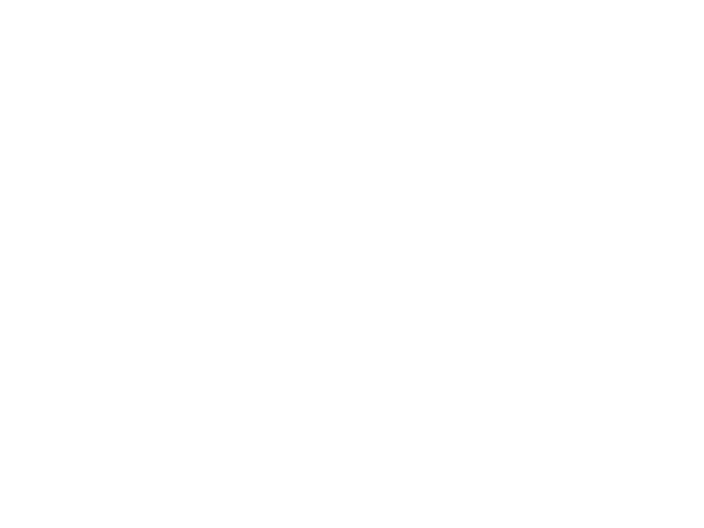

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx_test, yy_test, mean_flux)
#ax.set_zlim3d(0,0.1e-12)
plt.show()


In [22]:
'''
table = []
for k in range(0,len(xx_test)):
    table.append((xx_test[k], yy_test[k], mean_flux[k]))

f = open("M0.dat", 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()
'''

'\ntable = []\nfor k in range(0,len(xx_test)):\n    table.append((xx_test[k], yy_test[k], mean_flux[k]))\n\nf = open("M0.dat", \'w\')\nf.write(tabulate(table, tablefmt="plain"))\nf.close()\n'

In [23]:
import scipy as sp
import scipy.interpolate
splinemean = sp.interpolate.Rbf(xx_test,yy_test,mean_flux,function='thin_plate')
#splinedesvpad = sp.interpolate.Rbf(xx_test,yy_test,desv_pad,function='cubic')

In [24]:
x_grid = np.linspace(-10, 50, 61)
y_grid = np.linspace(3800, 7500, 44)
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')

<IPython.core.display.Javascript object>


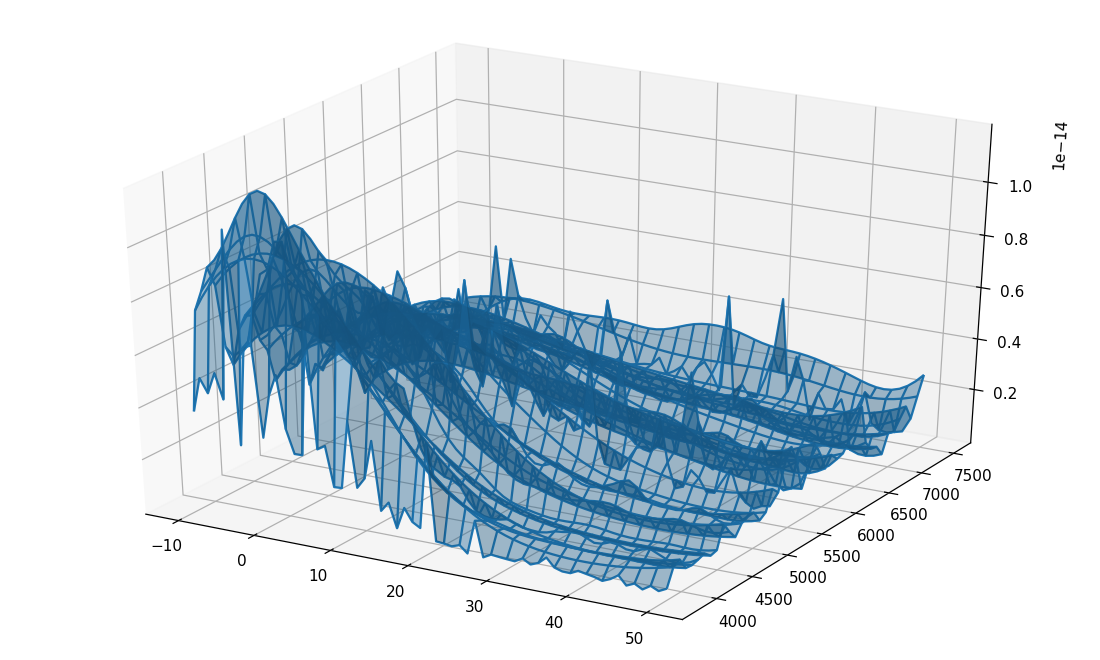

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy.interpolate as interp
#Z = interp.griddata((xx_test,yy_test),mean_flux,(B1,B2),method='cubic')
Z = splinemean(B1, B2)
%matplotlib notebook
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.4)
#ax.scatter3D(xx_test,yy_test,mean_flux, c='r')

plt.show()

In [26]:
y_grid

array([3800.        , 3886.04651163, 3972.09302326, 4058.13953488,
       4144.18604651, 4230.23255814, 4316.27906977, 4402.3255814 ,
       4488.37209302, 4574.41860465, 4660.46511628, 4746.51162791,
       4832.55813953, 4918.60465116, 5004.65116279, 5090.69767442,
       5176.74418605, 5262.79069767, 5348.8372093 , 5434.88372093,
       5520.93023256, 5606.97674419, 5693.02325581, 5779.06976744,
       5865.11627907, 5951.1627907 , 6037.20930233, 6123.25581395,
       6209.30232558, 6295.34883721, 6381.39534884, 6467.44186047,
       6553.48837209, 6639.53488372, 6725.58139535, 6811.62790698,
       6897.6744186 , 6983.72093023, 7069.76744186, 7155.81395349,
       7241.86046512, 7327.90697674, 7413.95348837, 7500.        ])

In [31]:

tablex = []
tabley = []
tablez = []

#stepx = (10+30)/40
stepy = (7000-8000)/39

gridx = -10
while gridx < 50:
    gridy = 3800
    while gridy <7500:
        tablex.append(gridx)
        tabley.append(gridy)
        tablez.append(splinemean(gridx,gridy))
        
        gridy += 86.04651163
    gridx += 1
        

In [32]:

table = []
for k in range(0,len(tablez)):
    table.append((tablex[k], tabley[k], tablez[k]))

f = open("realM0.dat", 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()


In [29]:
%matplotlib notebook
'''
histograma = plt.hist(histo_photo,range=[min(histo_photo), 30], bins=60)
#plt.savefig("histograma31_col_com_erros_med_6_2.jpg")
plt.show()
'''

'\nhistograma = plt.hist(histo_photo,range=[min(histo_photo), 30], bins=60)\n#plt.savefig("histograma31_col_com_erros_med_6_2.jpg")\nplt.show()\n'